In [1]:
!pip install ultralytics
!pip install onnxruntime
!pip install opencv-python
!pip install numpy
!pip install pillow

DEPRECATION: Configuring installation scheme with distutils config files is deprecated and will no longer work in the near future. If you are using a Homebrew or Linuxbrew Python, please see discussion at https://github.com/Homebrew/homebrew-core/issues/76621
Looking in indexes: https://pypi.org/simple, https://pypi.ngc.nvidia.com
DEPRECATION: Configuring installation scheme with distutils config files is deprecated and will no longer work in the near future. If you are using a Homebrew or Linuxbrew Python, please see discussion at https://github.com/Homebrew/homebrew-core/issues/76621

[notice] A new release of pip available: 22.3.1 -> 23.1.2
[notice] To update, run: python3.9 -m pip install --upgrade pip
DEPRECATION: Configuring installation scheme with distutils config files is deprecated and will no longer work in the near future. If you are using a Homebrew or Linuxbrew Python, please see discussion at https://github.com/Homebrew/homebrew-core/issues/76621
Looking in indexes: http

DEPRECATION: Configuring installation scheme with distutils config files is deprecated and will no longer work in the near future. If you are using a Homebrew or Linuxbrew Python, please see discussion at https://github.com/Homebrew/homebrew-core/issues/76621

[notice] A new release of pip available: 22.3.1 -> 23.1.2
[notice] To update, run: python3.9 -m pip install --upgrade pip
DEPRECATION: Configuring installation scheme with distutils config files is deprecated and will no longer work in the near future. If you are using a Homebrew or Linuxbrew Python, please see discussion at https://github.com/Homebrew/homebrew-core/issues/76621
Looking in indexes: https://pypi.org/simple, https://pypi.ngc.nvidia.com
DEPRECATION: Configuring installation scheme with distutils config files is deprecated and will no longer work in the near future. If you are using a Homebrew or Linuxbrew Python, please see discussion at https://github.com/Homebrew/homebrew-core/issues/76621

[notice] A new release 

In [3]:
from ultralytics import YOLO
import onnxruntime as ort
from PIL import Image, ImageDraw
import numpy as np
import cv2

In [4]:
# Export YOLOv8 model to ONNX
model = YOLO("yolov8m-seg.pt")
model.export(format="onnx")

Ultralytics YOLOv8.0.82 🚀 Python-3.9.16 torch-2.0.0 CPU
YOLOv8m-seg summary (fused): 245 layers, 27268704 parameters, 0 gradients, 110.2 GFLOPs

PyTorch: starting from yolov8m-seg.pt with input shape (1, 3, 640, 640) BCHW and output shape(s) ((1, 116, 8400), (1, 32, 160, 160)) (52.4 MB)

ONNX: starting export with onnx 1.14.0 opset 17...
ONNX: export success ✅ 2.8s, saved as yolov8m-seg.onnx (104.2 MB)

Export complete (4.8s)
Results saved to /Users/andrey/Projects/yolo_seg
Predict:         yolo predict task=segment model=yolov8m-seg.onnx imgsz=640 
Validate:        yolo val task=segment model=yolov8m-seg.onnx imgsz=640 data=coco.yaml 
Visualize:       https://netron.app


================ Diagnostic Run torch.onnx.export version 2.0.0 ================
verbose: False, log level: Level.ERROR
======================= 0 NONE 0 NOTE 0 WARNING 0 ERROR ========================



'yolov8m-seg.onnx'

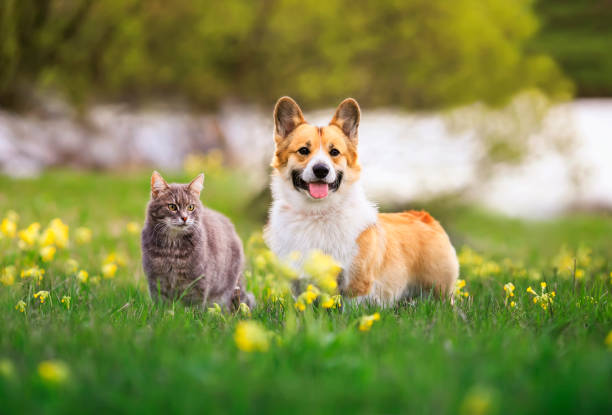

In [5]:
# Prepare input image
img = Image.open("cat_dog.jpg")
img

In [6]:
img_width, img_height = img.size
img = img.convert("RGB")
img = img.resize((640,640))

input = np.array(img)
input = input.transpose(2, 0, 1)
input = input.reshape(1,3,640,640).astype("float32")
input = input/255.0
input.shape

(1, 3, 640, 640)

In [7]:
# Run the model
model = ort.InferenceSession("yolov8m-seg.onnx")
outputs = model.run(None, {"images":input})

In [8]:
len(outputs)

2

In [9]:
# Process the outputs

output0 = outputs[0]
output1 = outputs[1]
print("Output0:",output0.shape,"Output1:",output1.shape)

Output0: (1, 116, 8400) Output1: (1, 32, 160, 160)


In [10]:
output0 = output0[0].transpose()
output1 = output1[0]
print("Output0:",output0.shape,"Output1:",output1.shape)

Output0: (8400, 116) Output1: (32, 160, 160)


In [12]:
boxes = output0[:,0:84]
masks = output0[:,84:]
print("Boxes:",boxes.shape,"Masks:",masks.shape)

Boxes: (8400, 84) Masks: (8400, 32)


In [13]:
output1 = output1.reshape(32,160*160)
print(masks.shape,output1.shape)

(8400, 32) (32, 25600)


In [14]:
# Join matrices by matrix multiplication
masks = masks @ output1
print(masks.shape)

(8400, 25600)


In [15]:
# Connect masks to boxes: move all columns from masks matrix to the right of boxes matrix
boxes = np.hstack([boxes,masks])
print(boxes.shape)

(8400, 25684)


In [16]:
# Parse "boxes" to get list of bounding boxes of detected objects,
# their segmentation masks and bounding polygons

yolo_classes = [
    "person", "bicycle", "car", "motorcycle", "airplane", "bus", "train", "truck", "boat",
    "traffic light", "fire hydrant", "stop sign", "parking meter", "bench", "bird", "cat", "dog", "horse",
    "sheep", "cow", "elephant", "bear", "zebra", "giraffe", "backpack", "umbrella", "handbag", "tie",
    "suitcase", "frisbee", "skis", "snowboard", "sports ball", "kite", "baseball bat", "baseball glove",
    "skateboard", "surfboard", "tennis racket", "bottle", "wine glass", "cup", "fork", "knife", "spoon",
    "bowl", "banana", "apple", "sandwich", "orange", "broccoli", "carrot", "hot dog", "pizza", "donut",
    "cake", "chair", "couch", "potted plant", "bed", "dining table", "toilet", "tv", "laptop", "mouse",
    "remote", "keyboard", "cell phone", "microwave", "oven", "toaster", "sink", "refrigerator", "book",
    "clock", "vase", "scissors", "teddy bear", "hair drier", "toothbrush"
]

def intersection(box1,box2):
    box1_x1,box1_y1,box1_x2,box1_y2 = box1[:4]
    box2_x1,box2_y1,box2_x2,box2_y2 = box2[:4]
    x1 = max(box1_x1,box2_x1)
    y1 = max(box1_y1,box2_y1)
    x2 = min(box1_x2,box2_x2)
    y2 = min(box1_y2,box2_y2)
    return (x2-x1)*(y2-y1) 

def union(box1,box2):
    box1_x1,box1_y1,box1_x2,box1_y2 = box1[:4]
    box2_x1,box2_y1,box2_x2,box2_y2 = box2[:4]
    box1_area = (box1_x2-box1_x1)*(box1_y2-box1_y1)
    box2_area = (box2_x2-box2_x1)*(box2_y2-box2_y1)
    return box1_area + box2_area - intersection(box1,box2)

def iou(box1,box2):
    return intersection(box1,box2)/union(box1,box2)

In [18]:
def sigmoid(z):
    return 1/(1 + np.exp(-z))

# parse segmentation mask
def get_mask(row, box, img_width, img_height):
    # convert mask to image (matrix of pixels)
    mask = row.reshape(160,160)
    mask = sigmoid(mask)
    mask = (mask > 0.5).astype("uint8")*255
    # crop the object defined by "box" from mask
    x1,y1,x2,y2 = box
    mask_x1 = round(x1/img_width*160)
    mask_y1 = round(y1/img_height*160)
    mask_x2 = round(x2/img_width*160)
    mask_y2 = round(y2/img_height*160)
    mask = mask[mask_y1:mask_y2,mask_x1:mask_x2]
    # resize the cropped mask to the size of object
    img_mask = Image.fromarray(mask,"L")
    img_mask = img_mask.resize((round(x2-x1),round(y2-y1)))
    mask = np.array(img_mask)
    return mask

# calculate bounding polygon from mask
def get_polygon(mask):
    contours = cv2.findContours(mask, cv2.RETR_LIST, cv2.CHAIN_APPROX_SIMPLE)
    polygon = [[contour[0][0],contour[0][1]] for contour in contours[0][0]]
    return polygon

# parse and filter all boxes
objects = []
for row in boxes:
    xc,yc,w,h = row[:4]
    x1 = (xc-w/2)/640*img_width
    y1 = (yc-h/2)/640*img_height
    x2 = (xc+w/2)/640*img_width
    y2 = (yc+h/2)/640*img_height
    prob = row[4:84].max()
    if prob < 0.5:
        continue
    class_id = row[4:84].argmax()
    label = yolo_classes[class_id]
    mask = get_mask(row[84:25684], (x1,y1,x2,y2), img_width, img_height)
    polygon = get_polygon(mask)
    objects.append([x1,y1,x2,y2,label,prob,mask,polygon])


# apply non-maximum suppression
objects.sort(key=lambda x: x[5], reverse=True)
result = []
while len(objects)>0:
    result.append(objects[0])
    objects = [object for object in objects if iou(object,objects[0])<0.7]

len(result)

2

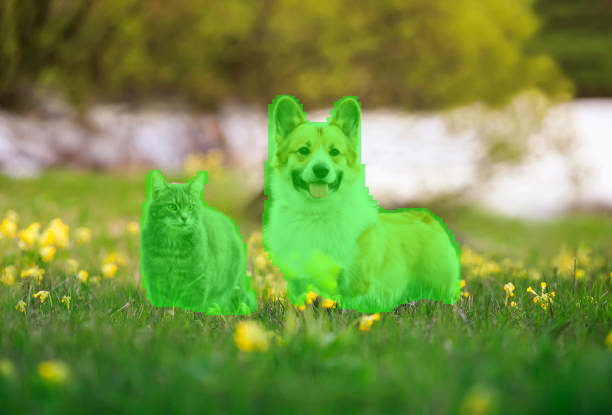

In [21]:
# display bounding polygons of detected objects
# on the image
img = Image.open("cat_dog.jpg")
draw = ImageDraw.Draw(img, "RGBA")
for object in result:
    [x1, y1, x2, y2, label, prob, mask, polygon] = object
    # move polygon from (0,0) to the top left point of detected object
    polygon = [(round(x1+point[0]),round(y1+point[1])) for point in polygon]
    draw.polygon(polygon, fill=(0, 255, 0, 125))

img